### import

We now use Tensorflow and GCN to simplify the problem from regression to classification

In [1]:
from __future__ import division
from __future__ import print_function

import time
import tensorflow as tf
from gcn.utils import *
from gcn.models import Model,MLP
from gcn.layers import *

import scipy as sp
from scipy import sparse
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### Return the random partition graph with a partition of sizes. A partition graph is a graph of communities with sizes defined by s in sizes. Nodes in the same group are connected with probability p_in and nodes of different groups are connected with probability p_out.

In [2]:
num_community = 1000
node = [10 for i in range(num_community)]
GG = nx.random_partition_graph(node,.3,.0,seed=66)
adj_GG = np.zeros((num_community, num_community))
for edge in GG.edges():
    row = edge[0] // num_community
    col = edge[1] // num_community
    if row != col:
        adj_GG[row][col]=1
        adj_GG[col][row]=1
    
adj_sparse = sparse.csr_matrix(adj_GG)

In [3]:
adj_sparse

<1000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

#### create subgraph

In [4]:
partition = GG.graph['partition']

In [5]:
adjlist = [[]]
for i in range(len(partition)):
    H = GG.subgraph(partition[i])
    adj = nx.adjacency_matrix(H).todense().tolist()
    for element in adj:
        adjlist[i].extend(element)
    adjlist.append([])
    
adjlist = adjlist[:-1]
adj_input = np.array(adjlist)
features_sparse = sparse.csr_matrix(adj_input)

In [6]:
features_sparse

<1000x100 sparse matrix of type '<class 'numpy.int64'>'
	with 27008 stored elements in Compressed Sparse Row format>

In [7]:
path_len = []
for i in range(num_community):
    try:
        path_len.append([nx.shortest_path_length(GG.subgraph(partition[i]), source=np.random.randint(low=i*10,high=(i+1)*10), target=np.random.randint(low=i*10,high=(i+1)*10))])
    except:
        path_len.append([0])

In [8]:
Train = []
for i in range(int(num_community*0.6)):
    Train.append(GG.subgraph(partition[i]))


Validation = []
for i in range(int(num_community*0.6),int(num_community*0.8)):
    Validation.append(GG.subgraph(partition[i]))
    
    
Test = []
for i in range(int(num_community*0.8),num_community):
    Test.append(GG.subgraph(partition[i]))

In [9]:
Train_path = path_len[:int(num_community*0.6)]
Validation_path = path_len[int(num_community*0.6):int(num_community*0.8)]
Test_path = path_len[int(num_community*0.8):]

### labels

labeled by the shortest path length in subgraph

In [10]:
# labels 
Label_Train = np.zeros((int(num_community*0.6),7))
Label_Test = np.zeros((int(num_community*0.2),7))
Label_Val = np.zeros((int(num_community*0.2),7))


for j in range(0,len(Train_path)):
    i=Train_path[j][0]
    Label_Train[j][i-1] = 1

for j in range(0,len(Validation_path)):
    i=Validation_path[j][0]
    Label_Val[j][i-1] = 1

for j in range(0,len(Test_path)):
    i=Test_path[j][0]
    Label_Test[j][i-1] = 1
    
label_tv = np.concatenate((Label_Train, Label_Val)) 
labels = np.concatenate((label_tv, Label_Test)) 
    
label_tv = np.concatenate((Label_Train, Label_Val)) 
labels = np.concatenate((label_tv, Label_Test)) 

In [11]:
labels.shape

(1000, 7)

### ytrain yval mask settings

In [12]:
def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)


# Settings
train_size = int(num_community*0.6)
val_size = int(num_community*0.2)
test_size = int(num_community*0.2)


idx_train = range(train_size)
idx_val = range(train_size, train_size+val_size)
idx_test = range(len(idx_val), len(idx_val)+test_size)


train_mask = sample_mask(idx_train, labels.shape[0])
val_mask = sample_mask(idx_val, labels.shape[0])
test_mask = sample_mask(idx_test, labels.shape[0])

y_train = np.zeros(labels.shape)
y_val = np.zeros(labels.shape)
y_test = np.zeros(labels.shape)
y_train[train_mask, :] = labels[train_mask, :]
y_val[val_mask, :] = labels[val_mask, :]
y_test[test_mask, :] = labels[test_mask, :]

### assign value for input

In [13]:
adj = adj_sparse
features = features_sparse   
y_train = y_train 
y_val = y_val
train_mask = train_mask
val_mask = val_mask

In [14]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
#         self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
#                                               self.placeholders['labels_mask'])
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

### support preprocess

In [15]:
def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.sparse.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.sparse.diags(d_inv_sqrt, 0)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.sparse.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)
#     adj_square = np.power(adj,2).tocoo()
#     return sparse_to_tuple(adj_square)



num_supports = 1
model_func = GCN
support = [preprocess_adj(adj)]


print ("preprocessing has completed!!")

preprocessing has completed!!


### Preprocess Features!!!!!!!!!!!!

In [16]:
def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.sparse.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx


def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv1 = np.power(rowsum, -0.5).flatten()
    r_inv2 = np.power(rowsum, -0.5).flatten()
    r_inv = np.multiply(r_inv1, r_inv2)
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.sparse.diags(r_inv, 0)
    features = r_mat_inv.dot(features)
    return sparse_to_tuple(features)


features = preprocess_features(features)



print ("feature preprocessing has completed!!")

feature preprocessing has completed!!


In [17]:
def masked_softmax_cross_entropy(preds, labels, mask):
    """Softmax cross-entropy loss with masking."""
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

def masked_mean_square_error(preds,labels,mask):
    """ L-2 loss """
    loss = tf.nn.l2_loss(preds - labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

def masked_accuracy(preds, labels, mask):
    """Accuracy with masking."""
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)

In [18]:
# Set random seed
seed = 66
np.random.seed(seed)
tf.set_random_seed(seed)

# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS


flags.DEFINE_string('model', 'gcn', 'Model string.')  # 'gcn', 'gcn_cheby', 'dense'
# flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_float('learning_rate', 0.05, 'Initial learning rate.')

flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 1024, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')
# flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')

flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
# flags.DEFINE_float('weight_decay', 0, 'Weight for L2 loss on embedding matrix.')


flags.DEFINE_integer('early_stopping', 100, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')

In [19]:
if FLAGS.model == 'gcn':
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif FLAGS.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, FLAGS.max_degree)
    num_supports = 1 + FLAGS.max_degree
    model_func = GCN
elif FLAGS.model == 'dense':
    support = [preprocess_adj(adj)]  # Not used
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(FLAGS.model))

# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

# Create model
model = model_func(placeholders, input_dim=features[2][1], logging=True)

# Initialize session
sess = tf.Session()


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

In [20]:
def construct_feed_dict(features, support, labels, labels_mask, placeholders):
    """Construct feed dictionary."""
    feed_dict = dict()
    feed_dict.update({placeholders['labels']: labels})
    feed_dict.update({placeholders['labels_mask']: labels_mask})
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['support'][i]: support[i] for i in range(len(support))})
    feed_dict.update({placeholders['num_features_nonzero']: features[1].shape})
    return feed_dict

In [21]:
# Initialize weights not L2 loss
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

#     Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 1.99166 train_acc= 0.13000 val_loss= 1.66598 val_acc= 0.25500 time= 0.19536
Epoch: 0002 train_loss= 1.61621 train_acc= 0.34333 val_loss= 1.96722 val_acc= 0.25500 time= 0.14587
Epoch: 0003 train_loss= 1.82361 train_acc= 0.34500 val_loss= 1.68804 val_acc= 0.37000 time= 0.11707
Epoch: 0004 train_loss= 1.69459 train_acc= 0.25500 val_loss= 1.70461 val_acc= 0.19500 time= 0.11852
Epoch: 0005 train_loss= 1.66928 train_acc= 0.22167 val_loss= 1.73725 val_acc= 0.15500 time= 0.10904
Epoch: 0006 train_loss= 1.65543 train_acc= 0.21833 val_loss= 1.71819 val_acc= 0.24500 time= 0.10805
Epoch: 0007 train_loss= 1.61230 train_acc= 0.36167 val_loss= 1.70030 val_acc= 0.25500 time= 0.10302
Epoch: 0008 train_loss= 1.58525 train_acc= 0.34833 val_loss= 1.69999 val_acc= 0.26000 time= 0.10101
Epoch: 0009 train_loss= 1.58688 train_acc= 0.35167 val_loss= 1.70188 val_acc= 0.25000 time= 0.11645
Epoch: 0010 train_loss= 1.58141 train_acc= 0.36667 val_loss= 1.70178 val_acc= 0.27500 time= 0.11466


Epoch: 0083 train_loss= 1.57947 train_acc= 0.54167 val_loss= 2.12602 val_acc= 0.28000 time= 0.13265
Epoch: 0084 train_loss= 1.59623 train_acc= 0.51000 val_loss= 2.08237 val_acc= 0.29000 time= 0.12426
Epoch: 0085 train_loss= 1.57297 train_acc= 0.54167 val_loss= 2.08111 val_acc= 0.28000 time= 0.10490
Epoch: 0086 train_loss= 1.60042 train_acc= 0.51667 val_loss= 2.11711 val_acc= 0.27000 time= 0.15541
Epoch: 0087 train_loss= 1.58412 train_acc= 0.57167 val_loss= 2.17390 val_acc= 0.28500 time= 0.15572
Epoch: 0088 train_loss= 1.60808 train_acc= 0.53000 val_loss= 2.14434 val_acc= 0.29000 time= 0.17320
Epoch: 0089 train_loss= 1.59600 train_acc= 0.52500 val_loss= 2.09588 val_acc= 0.27500 time= 0.12182
Epoch: 0090 train_loss= 1.65821 train_acc= 0.50500 val_loss= 2.10672 val_acc= 0.29000 time= 0.12645
Epoch: 0091 train_loss= 1.59841 train_acc= 0.52167 val_loss= 2.12757 val_acc= 0.30000 time= 0.11515
Epoch: 0092 train_loss= 1.59365 train_acc= 0.56833 val_loss= 2.14207 val_acc= 0.28000 time= 0.12970


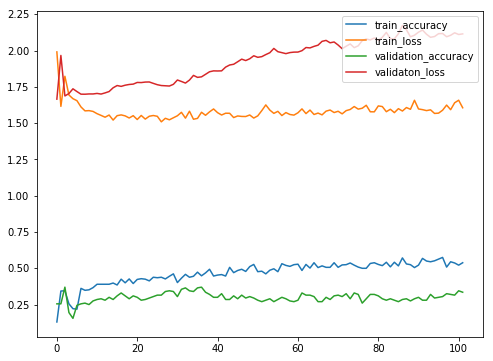

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend(loc=1)
axes = plt.gca()
# axes.set_ylim([0,1])
# plt.savefig('gcn.svg', format='svg')
plt.show()

In [23]:
# Testing
test_cost, test_acc, test_duration = evaluate(features, support, y_test, test_mask, placeholders)
print("Test set results:", "cost=", "{:.5f}".format(test_cost),
      "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))

Test set results: cost= 1.33465 accuracy= 0.74500 time= 0.03698
